## Voltage ramp benchmarking
This notebook looks at various components of a standard QT fridge setup to identify which component sets the bottleneck for ramping voltages and gives some idea of what those ramp rate limits are.  Notebook uses a Keysight MSOS254A scope and Rigol DG1062 function generator.

In [1]:
import qcodes as qc
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from qcodes.instrument_drivers.Keysight.Infiniium import Infiniium
from qcodes.instrument_drivers.rigol.DG1062 import DG1062

station = qc.Station()
mso = Infiniium("mso",  address="TCPIP0::169.254.45.211")
rigol =  DG1062("rigol", address='TCPIP0::169.254.187.99')
station.add_component(mso)
station.add_component(rigol)

Connected to: KEYSIGHT TECHNOLOGIES MSOS254A (serial:MY57480103, firmware:06.10.00803) in 0.17s
Connected to: Rigol Technologies DG1062Z (serial:DG1ZA195006397, firmware:03.01.12) in 0.04s


e:\code\qcodes\qcodes\instrument\parameter.py:245: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
Snapshot: Could not update parameter: period on rigol_burst
Snapshot: Could not update parameter: period on rigol_burst


'rigol'

## Configure the scope

In [37]:
for i in range(4):
    mso.channels[i].display(False)
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

In [38]:
mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

In [39]:
nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

## Setup Rigol function generator

In [24]:
rigol.ch1.impedance('HighZ')
rigol.ch1.ramp(freq=500, ampl=1, offset=0.5, phase=0) #freq, ampl, offset, phase

DataSet:
   location = 'data/2018-08-28/#001_{name}_09-20-43'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-28 09:20:52


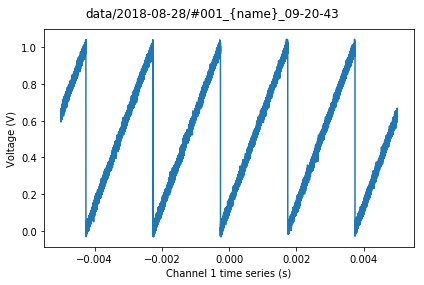

In [25]:
mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

This matches what is on the front panel, and (not surprisingly) there is no distortion for a 500Hz triangle wave when the function generator is connected to the scope by a 4' long BNC cable

## Impact of room temperature cabling
Connect the function generator to a Sydney breakout box via a 4' BNC cable then connect the breakout box to a second breakout box via 3m micro-D cable (with twisted pairs) and then via 4' BNC cable to scope

DataSet:
   location = 'data/2018-08-28/#002_{name}_13-26-45'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-28 13:26:48


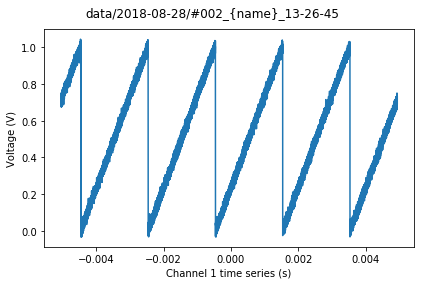

In [26]:
mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

No appreciable change

Try increasing the frequency until things do start to round off

In [30]:
rigol.ch1.ramp(freq=500000, ampl=1, offset=0.5, phase=0)

In [66]:
# for i in range(4):
#     mso.channels[i].display(False)
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

In [67]:
mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

In [68]:
nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

DataSet:
   location = 'data/2018-08-28/#006_{name}_13-48-29'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-28 13:48:31


<IPython.core.display.Javascript object>


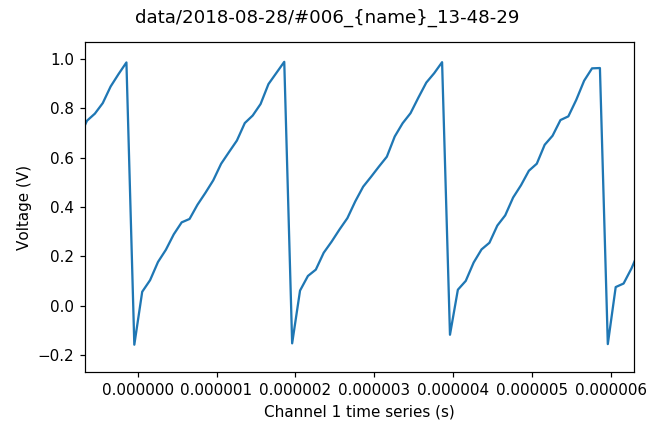

In [72]:
%matplotlib notebook
mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

Even a 500kHz ramp seems more or less unaffected by the micro-D cables and breakout box

## Add QDevil filter
Repeat the previous test but add a QDevil RC filter inline

In [73]:
#Back to 500Hz ramp
rigol.ch1.ramp(freq=500, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-28/#007_{name}_15-04-17'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-28 15:04:19


<IPython.core.display.Javascript object>


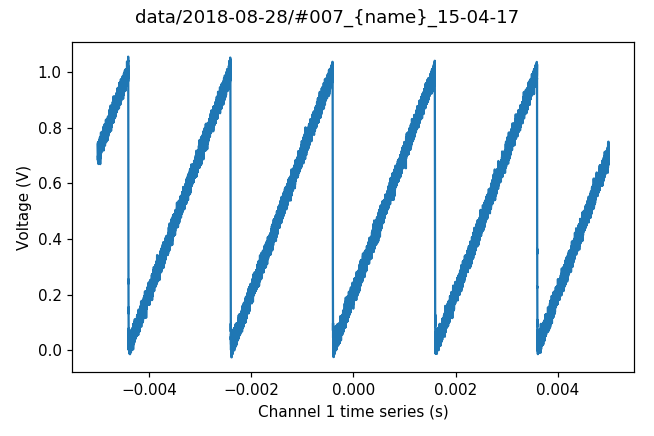

In [74]:
mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

Once again no rounding of the ramp.  Try going to higher frequency again.

In [77]:
rigol.ch1.ramp(freq=50000, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-28/#008_{name}_15-06-31'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-28 15:06:33


<IPython.core.display.Javascript object>


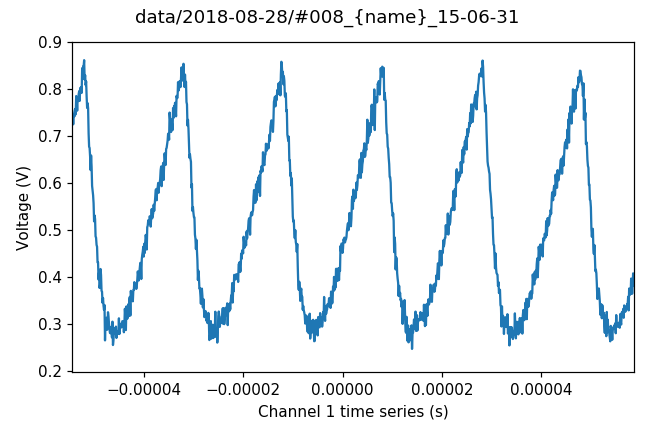

In [79]:
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

Now we see considerable rounding and attenuation at 50kHz ramp frequency which is expected (from datasheet, should expect 3dB point ~50kHz)

## Add probe and flex PCB
Add (inline) one of the QT fridge bottom loading probes with the flex PCB plugged in to the top of the probe and the 100-pin Micro-D connector on the flex PCB plugged in to a shorting plug.  In other words, the signal from the function generator travels through a BNC cable, breakout box, 3m micro-D cable, QDevil filter, up the probe, through the flex PCB, back into the probe, through a second 3m micro-D cable, back into the breakout box, then through one final BNC cable to the scope.  The probe should give a rough approximation of the impact of the wiring inside the fridge since it is made of similar twisted pairs and thermalization bobbins.

## Add motherboard
Add a Gen5.0 motherboard with the diagnostic daughterboard (e.g. all DC lines shorted together) inline to the previous chain.  This should give a reasonable approximation of the entire DC signal chain in an actual experiment